# Fine Tuning with PEFT

In [1]:
!pip install --upgrade typing_extensions==4.12.2
!pip install -q accelerate peft bitsandbytes transformers trl datasets flash-attn tensorboard wandb


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, SFTConfig

## Parameters

- Training

In [7]:
#모델이 예측한 결과와 체크포인트가 저장될 출력 디렉터리
output_dir = "./results"

# 훈련 에포크 수
num_train_epochs = 1

# fp16/bf16 학습 활성화(A100으로 bf16을 True로 설정)
fp16 = False
bf16 = False

# 훈련용 배치 크기
per_device_train_batch_size = 1 #4

# 평가용 배치 크기
per_device_eval_batch_size = 1 #4

# 그래디언트를 누적할 업데이트 스텝 횟수
gradient_accumulation_steps = 1

# 그래디언트 체크포인트 활성화
gradient_checkpointing = True

# 그래디언트 클리핑을 위한 최대 그래디언트 노름을 설정.
# 그래디언트 클리핑은 그래디언트의 크기를 제한하여 훈련 중 안정성을 높임.
# Maximum gradient normal (그래디언트 클리핑) 0.3으로 설정
max_grad_norm = 0.3

# 초기 학습률 AdamW 옵티마이저
learning_rate = 2e-4

# bias/LayerNorm 가중치를 제외하고 모든 레이어에 적용할 Weight decay 값
weight_decay = 0.001

# 옵티마이저 설정
optim = "adamw_torch_fused" # "paged_adamw_32bit" # adamw_torch_fused

# 학습률 스케줄러의 유형 설정, 여기서는 코사인 스케줄러 사용
lr_scheduler_type = "constant"

# 훈련 스텝 수(num_train_epochs 재정의)
max_steps = -1

# (0부터 learning rate까지) 학습 초기에 학습률을 점진적으로 증가시키 linear warmup 스텝의 Ratio
warmup_ratio = 0.03

# 시퀀스를 동일한 길이의 배치로 그룹화, 메모리 절약 및 훈련 속도를 높임
group_by_length = True

# X 업데이트 단계마다 체크포인트 저장
save_steps = 100 #25

# 매 X 업데이트 스텝 로그
logging_steps = 100 #25

- Supervised Fine-Tuning

In [8]:
# 최대 시퀀스 길이 설정
max_seq_length = 7994

# 동일한 입력 시퀀스에 여러 개의 짧은 예제를 넣어 효율성을 높일 수 있음
packing = True #False

# Load the entire model on the GPU 0
device_map = "auto" #{"": 0}

## [Load Dataset](https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k)

In [9]:
# The instruction dataset to use
dataset_name = "nlpai-lab/openassistant-guanaco-ko" # 한국어 데이터셋
# dataset_name = "mlabonne/guanaco-llama2-1k"

- openassistant-guanaco-ko

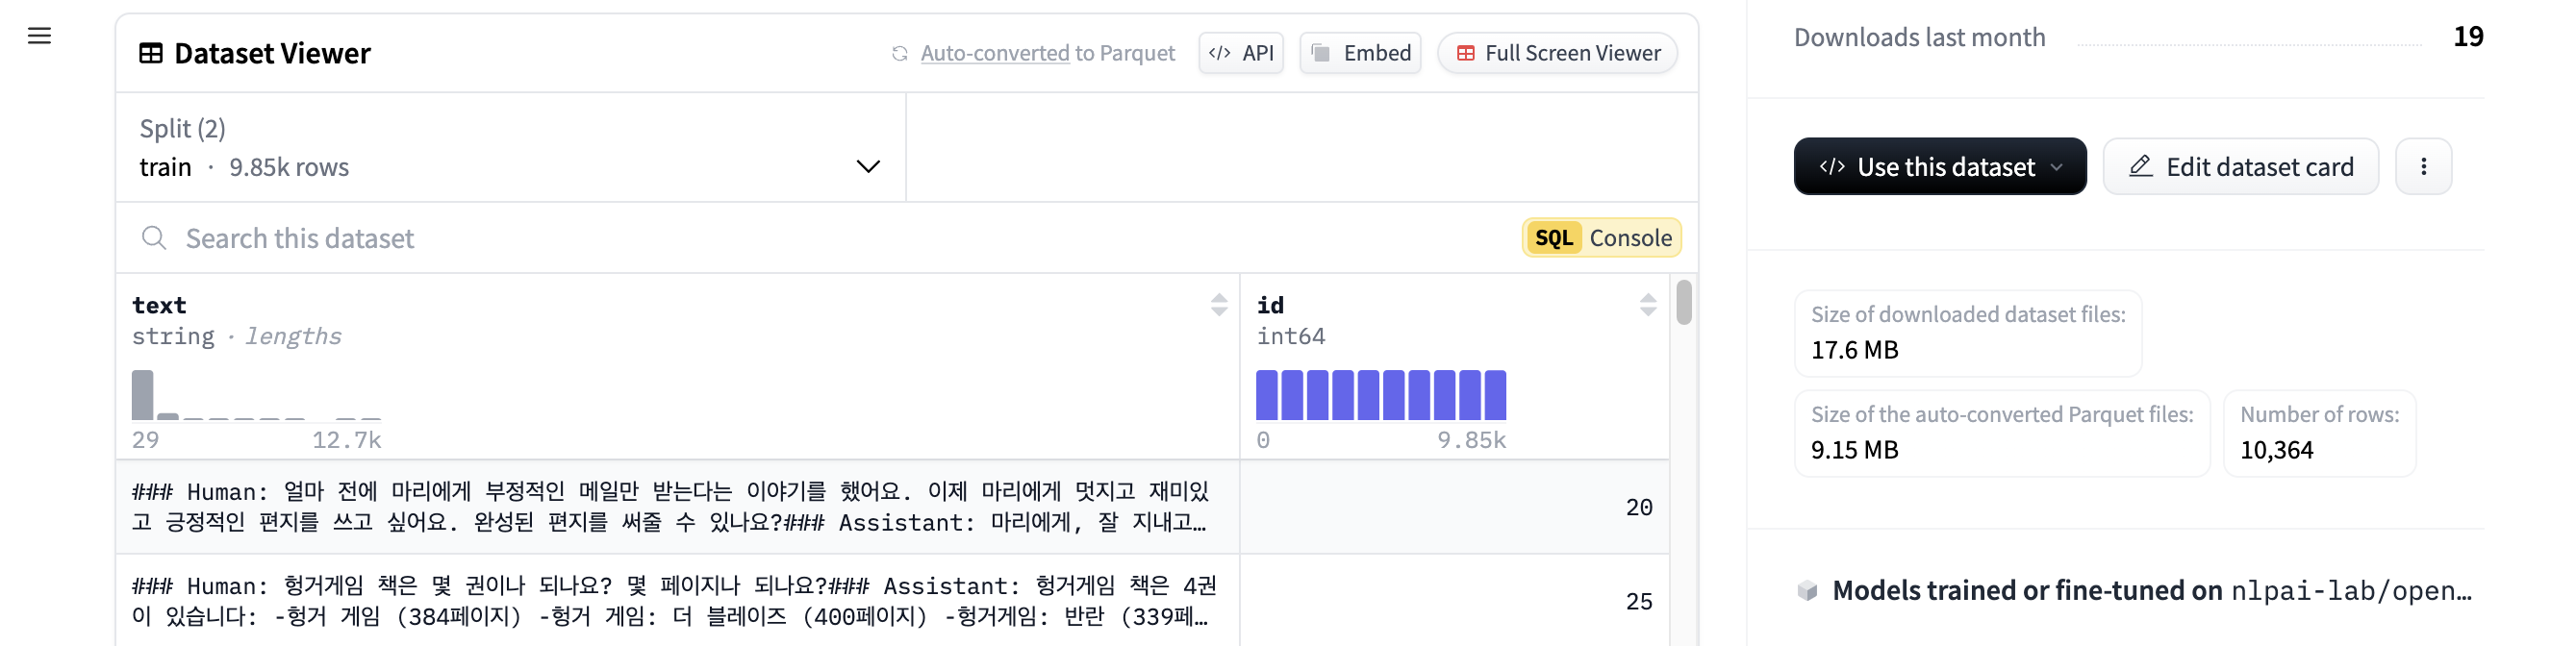

- mlabonne/guanaco-llama2-1k

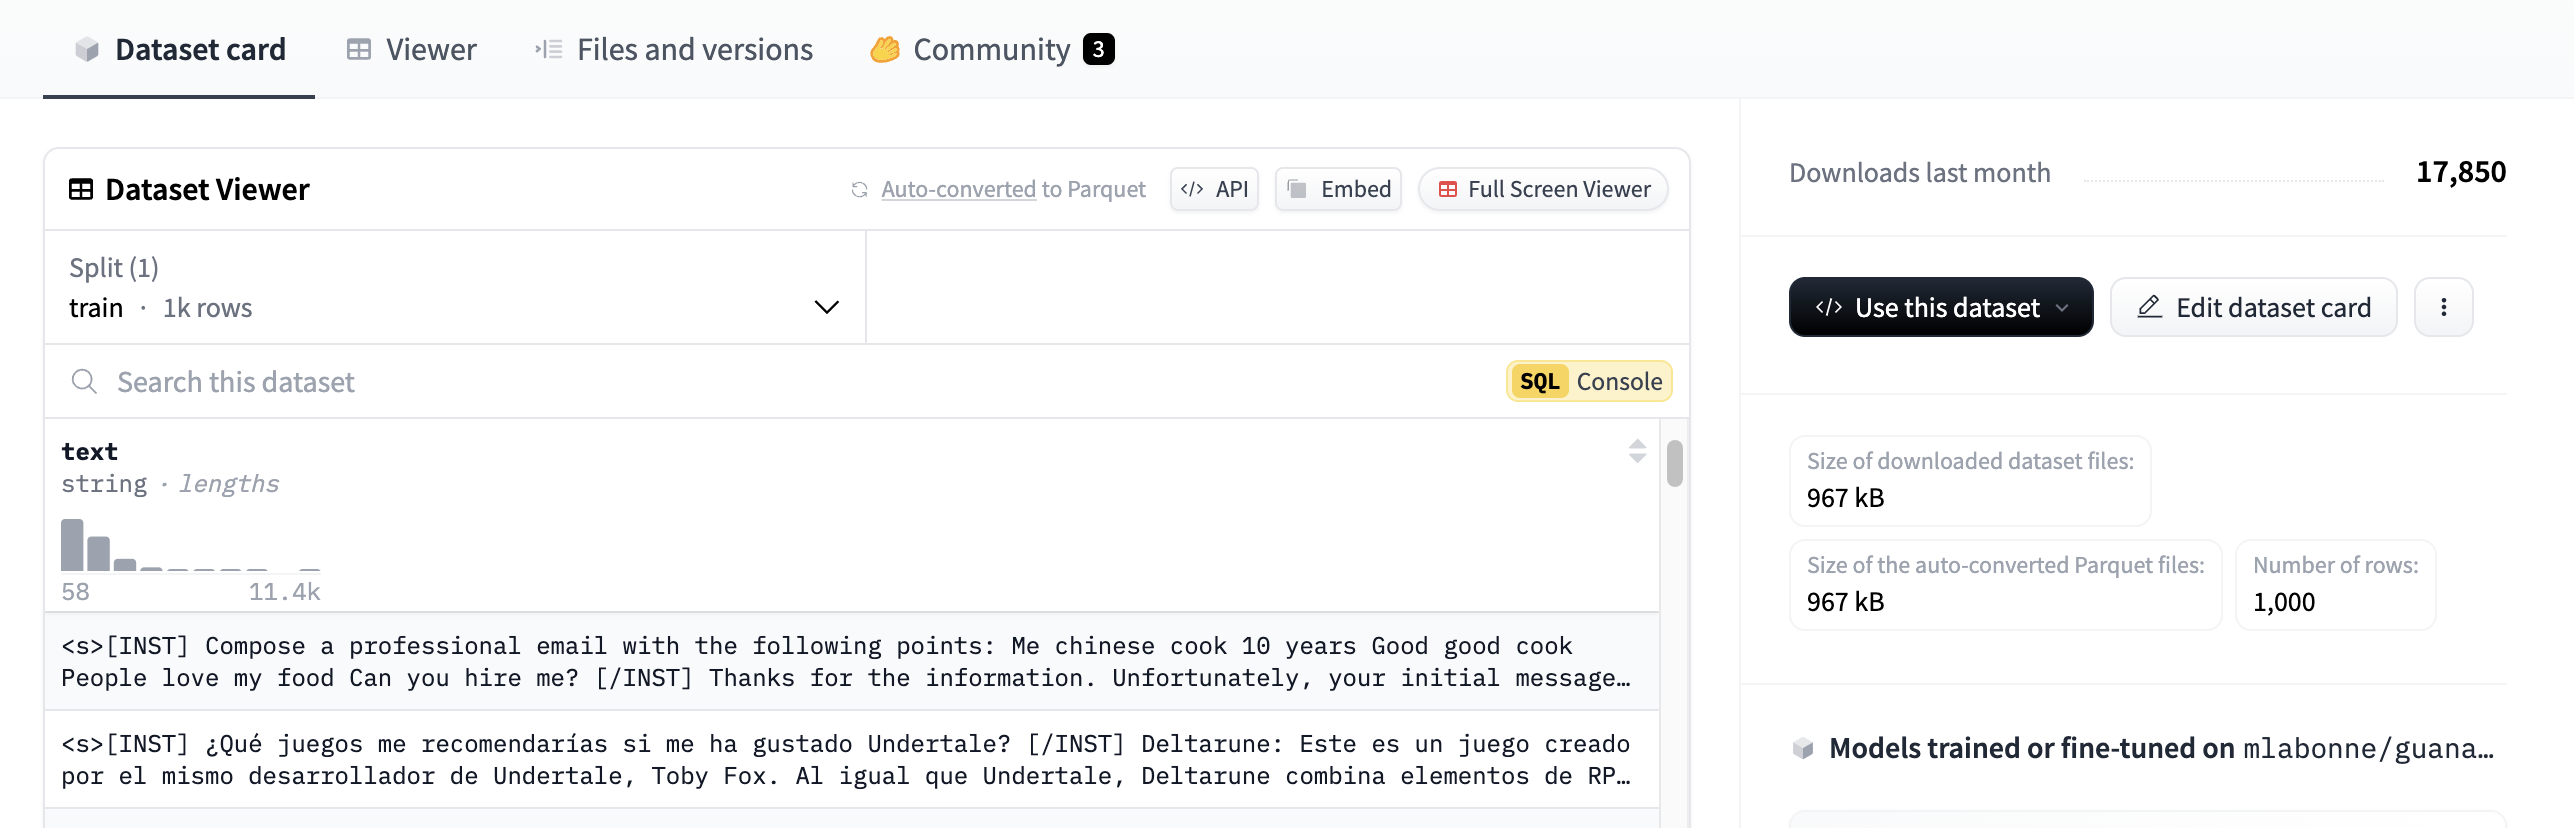

In [14]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

len(dataset)

9846

In [ ]:
# 학습 시간이 오래걸리기 때문에 랜덤하게 1000개만 추출 
dataset = dataset.shuffle(seed=42).select(range(1000))

len(dataset)

1000

## Model with Quantization

In [16]:
# Hugging Face 허브에서 훈련하고자 하는 모델을 가져와서 이름 지정
# model_name = "LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct" #"LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"
model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

# fine-tuning(미세 조정)을 거친 후의 모델에 부여될 새로운 이름을 지정하는 변수
new_model = "EXAONE-3.5-7.8B-fine-tuning"

In [17]:
# Quantization config 세팅 -> 모델이 사용하는 vram을 최소화하기
bnb_config = BitsAndBytesConfig(
    # 모델을 4비트로 로드할지 여부를 결정
    load_in_4bit=True,
    # double quantization으로 양자화 오류를 줄입니다.
    bnb_4bit_use_double_quant=True,
    # 다양한 양자화 종류 중 nf4를 선택
    bnb_4bit_quant_type="nf4",
    # 계산에 사용될 데이터 타입을 설정
    # llama는 16비트 부동 소수를 사용해 학습됐습니다.
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # 모델을 사용할 디바이스를 자동으로 설정합니다.
    device_map="auto",
    torch_dtype=torch.bfloat16,
    # 양자화 설정을 적용합니다.
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False
model.config.pretraining_tp = 1


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Tokenizer

In [18]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 동일한 batch 내에서 입력의 크기를 동일하기 위해서 사용하는 Padding Token을 End of Sequence라고 하는 Special Token으로 사용한다.
tokenizer.pad_token = tokenizer.eos_token
# Fix weird overflow issue with fp16 training. Padding을 오른쪽 위치에 추가한다.
tokenizer.padding_side = "right"

## Training

- Set training parameters

In [19]:
# Set training parameters
training_arguments = SFTConfig(
    output_dir=output_dir,
    dataset_text_field="text",
    packing=packing,                                          # 패킹은 여러 시퀀스를 하나의 고정된 크기 내에서 묶어 처리하는 방법입니다. 이를 통해 효율적인 배치 처리가 가능합니다.
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,  # 배치 사이즈 설정 합니다.
    gradient_accumulation_steps=gradient_accumulation_steps,  # 스텝마다 역전파 및 가중치 업데이트합니다.
    optim=optim,                                              # 메모리 효율화할 수 있는 fused AdamW 옵티마이저 사용합니다.
    save_steps=save_steps,
    logging_steps=logging_steps,                              # 스텝마다 로그 기록합니다.
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb",
    # Arguments
    gradient_checkpointing=True,                            # 메모리 절약을 위해 그래디언트 체크포인팅 사용합니다.
    # gradient_checkpointing_kwargs={'use_reentrant':False} # OR gradient_checkpointing_kwargs={'use_reentrant':True}

)

### LoRA

In [20]:
# LoRA에서 사용하는 low-rank matrices 어텐션 차원을 정의. 여기서는 64로 설정
# 값이 크면 클수록 더 많은 수정이 이루어지며, 모델이 더 복잡해질 수 있음
lora_r = 32 # 64, 32, 16

# LoRA 적용 시 가중치에 곱해지는 스케일링 요소. 여기서는 16으로 설정
# LoRA가 적용될 때 원래 모델의 가중치에 얼마나 영향을 미칠지 결정. 높은 값은 가중치 조정의 강도를 증가시킴
lora_alpha = 16

# Dropout probability for LoRA layers   # LoRA 층에 적용되는 드롭아웃 확률. 여기서는 0.1 (10%)로 설정
# 일부 네트워크 연결을 무작위로 비활성화하여 모델의 강건함에 기여
lora_dropout = 0.05

In [21]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,                    # Lora의 저차원 공간의 랭크를 지정합니다. 랭크가 높을수록 모델의 표현력이 증가하지만, 계산 비용도 증가합니다.
    bias="none",                 # Lora 적용 시 바이어스를 사용할지 여부를 설정합니다. "none"으로 설정하면 바이어스를 사용하지 않습니다.
    task_type="CAUSAL_LM",       # 미세 조정 작업 유형을 CAUSAL_LM으로 지정하여 언어 모델링 작업을 수행합니다.
    target_modules=[
      "q_proj", # Decoder layer 에 있는 Query Layer 이다.
      "k_proj", # # Decoder layer 에 있는 Query Layer 이다
      "v_proj", # Decoder layer 에 있는 Query Layer 이다
      "o_proj", # Decoder layer 에 있는 Self-Attention Layer 이다
      "gate_proj", # 특정 입력을 조절하거나 필터링하기 위해 게이트 메커니즘을 적용하는 모듈입니다.
      "up_proj", # 입력의 차원을 증가시키는 모듈입니다. 예를 들어, 입력 벡터의 크기를 증가시켜 더 많은 정보를 담을 수 있도록 합니다.
      "down_proj", # 입력의 차원을 감소시키는 모듈입니다. 예를 들어, 입력 벡터의 크기를 줄여 계산 효율성을 높입니다.
      # "lm_head", # Decoder Model 에서 Output 을 도출하는 CLM layer 이다. (마지막 Layer 이다.)
    ]
)

- Set supervised fine-tuning parameters

In [22]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_arguments
)

The repository LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct .
 You can inspect the repository content at https://hf.co/LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Padding-free training is enabled, but the attention implementation is not set to 'flash_attention_2'. Padding-free training flattens batches into a single sequence, and 'flash_attention_2' is the only known attention mechanism that reliably supports this. Using other implementations may lead to unexpected behavior. To ensure compatibility, set `attn_implementation='flash_attention_2'` in the model configuration, or verify that your attention mechanism can handle flattened sequences.
You are using packing, but the attention implementation is not set to 'flash_attention_2' or 'kernels-community/vllm-flash-attn3'. Packing flattens batches into a single sequence, and Flash Attention is the only known attention mechanisms that reliably support this. Using other implementations may lead to cross-contamination between batches. To avoid this, either disable packing by setting `packing=False`, or set `attn_implementation='flash_attention_2'` or `attn_implementation='kernels-community/vllm-flash

Adding EOS to train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

- Train model

In [23]:
# Train model
trainer.train()


wandb: Currently logged in as: goodwon593 (goodwon593-student-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,1.864000
200,1.716400
300,1.696300


TrainOutput(global_step=350, training_loss=1.7409645080566407, metrics={'train_runtime': 230.1539, 'train_samples_per_second': 1.521, 'train_steps_per_second': 1.521, 'total_flos': 4613948098037760.0, 'train_loss': 1.7409645080566407, 'entropy': 1.6485951673984527, 'num_tokens': 356966.0, 'mean_token_accuracy': 0.6312457537651062, 'epoch': 1.0})

### Save trained model

In [24]:
# Save trained model
trainer.model.save_pretrained(new_model, save_embedding_layers=True)

### Inference

In [26]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "주식이란 무엇인가요?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 주식이란 무엇인가요? [/INST] 주식이란 회사의 소유권을 나타내는 증서로, 회사가 수익을 창출할 때 주주에게 배당금을 지급할 권리가 있는 것입니다.


# 모델 성능 비교: 원본 모델 vs PEFT 모델

이 섹션에서는 원본 모델과 PEFT로 파인튜닝된 모델의 성능을 다양한 지표로 비교해보겠습니다.


## 필요한 라이브러리 설치 및 임포트

In [ ]:
%pip install -q evaluate rouge_score matplotlib seaborn

In [ ]:
import evaluate
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import time
from tqdm import tqdm

# 필요하면 '-' 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

print("평가 라이브러리 로드 완료!")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
평가 라이브러리 로드 완료!


## 원본 모델과 PEFT 모델 로드

In [ ]:
print("모델 로딩 중...")

# 원본 모델 로드
original_model = AutoModelForCausalLM.from_pretrained(
    "good593/EXAONE-3.5-2.4B-fine-tuning",
    pad_token_id=tokenizer.eos_token_id,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="auto"
)

# PEFT 모델 로드 (훈련된 어댑터)
peft_model = PeftModel.from_pretrained(
    original_model,
    new_model,  # PEFT 모델 경로
    torch_dtype=torch.float16
)

print("모델 로딩 완료!")
print(f"원본 모델 파라미터 수: {sum(p.numel() for p in original_model.parameters()):,}")
print(f"PEFT 모델 파라미터 수: {sum(p.numel() for p in peft_model.parameters()):,}")
# print(f"PEFT 어댑터 파라미터 수: {sum(p.numel() for p in peft_model.peft_config['default'].target_modules):,}")
peft_params = sum(
    p.numel() for n, p in peft_model.named_parameters() if any(tm in n for tm in peft_model.peft_config['default'].target_modules)
)
print(f"PEFT 어댑터 파라미터 수: {peft_params:,}")


모델 로딩 중...
모델 로딩 완료!
원본 모델 파라미터 수: 2,416,386,560
PEFT 모델 파라미터 수: 2,416,386,560
PEFT 어댑터 파라미터 수: 305,971,200


## 성능 평가 함수들 정의

In [ ]:
def generate_text(model, tokenizer, prompt, max_length=200, temperature=0.7, top_p=0.9):
    """모델로부터 텍스트 생성"""
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            num_return_sequences=1
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # 프롬프트 부분 제거하고 생성된 부분만 반환
    generated_text = generated_text[len(prompt):].strip()
    return generated_text

In [ ]:
bleu_metric = evaluate.load("bleu")

def calculate_bleu_score(predictions, references):
    """BLEU 점수 계산"""
    results = bleu_metric.compute(predictions=predictions, references=references)
    return results['bleu']

In [ ]:
rouge_metric = evaluate.load("rouge")

def calculate_rouge_score(predictions, references):
    """ROUGE 점수 계산"""
    results = rouge_metric.compute(predictions=predictions, references=references)
    return {
        'rouge1': results['rouge1'],
        'rouge2': results['rouge2'],
        'rougeL': results['rougeL']
    }

In [ ]:
import math

perplexity_metric = evaluate.load("perplexity", module_type="metric")

def calculate_perplexity(model, tokenizer, texts, device='cuda'):
    model.to(device)
    model.eval()
    losses = []
    for text in texts:
        encodings = tokenizer(text, return_tensors='pt')
        input_ids = encodings.input_ids.to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            # outputs.loss는 이미 배치 평균 CrossEntropy
            loss = outputs.loss.item()
            losses.append(loss)
    
    mean_loss = sum(losses) / len(losses)
    perplexity = math.exp(mean_loss)
    return perplexity

In [ ]:
def evaluate_model_performance(model, tokenizer, test_prompts, test_answers, model_name):
    """모델 성능 종합 평가"""
    print(f"\n{model_name} 모델 평가 중...")
    
    predictions = []
    generation_times = []
    
    for i, prompt in enumerate(tqdm(test_prompts, desc=f"{model_name} 생성 중")):
        start_time = time.time()
        generated_text = generate_text(model, tokenizer, prompt)
        end_time = time.time()
        
        predictions.append(generated_text)
        generation_times.append(end_time - start_time)
    
    # BLEU 점수 계산
    bleu_score = calculate_bleu_score(predictions, test_answers)
    
    # ROUGE 점수 계산
    rouge_scores = calculate_rouge_score(predictions, test_answers)
    
    # Perplexity 계산
    perplexity = calculate_perplexity(model, tokenizer, test_answers)
    
    # 평균 생성 시간
    avg_generation_time = np.mean(generation_times)
    
    results = {
        'model_name': model_name,
        'bleu': bleu_score,
        'rouge1': rouge_scores['rouge1'],
        'rouge2': rouge_scores['rouge2'],
        'rougeL': rouge_scores['rougeL'],
        'perplexity': perplexity,
        'avg_generation_time': avg_generation_time,
        'predictions': predictions
    }
    
    return results

print("성능 평가 함수 정의 완료!")


성능 평가 함수 정의 완료!


## 테스트 데이터셋 준비

In [ ]:
test_prompts = [
    "<s>[INST] 인공지능의 미래는 어떻게 될까요? [/INST]",
    "<s>[INST] 기후변화에 대응하는 방법을 알려주세요. [/INST]",
    "<s>[INST] 건강한 생활습관에 대해 설명해주세요. [/INST]",
    "<s>[INST] 한국의 전통문화에 대해 소개해주세요. [/INST]",
    "<s>[INST] 스마트폰의 장단점은 무엇인가요? [/INST]",
    "<s>[INST] 독서의 중요성에 대해 말해주세요. [/INST]",
    "<s>[INST] 환경보호를 위한 실천방안을 제시해주세요. [/INST]",
    "<s>[INST] 성공적인 리더십이란 무엇인가요? [/INST]",
    "<s>[INST] 디지털 시대의 개인정보 보호 방법을 알려주세요. [/INST]",
    "<s>[INST] 창의적 사고를 기르는 방법은 무엇인가요? [/INST]"
]

test_answers = [
    "인공지능의 미래는 매우 밝습니다. AI 기술이 계속 발전하면서 의료, 교육, 교통 등 다양한 분야에서 혁신을 가져올 것입니다. 하지만 윤리적 고려사항과 일자리 변화에 대한 대비도 필요합니다.",
    "기후변화에 대응하기 위해서는 개인적으로는 에너지 절약, 친환경 교통수단 이용, 재활용 등을 실천하고, 사회적으로는 재생에너지 확대, 탄소중립 정책 추진 등이 필요합니다.",
    "건강한 생활습관으로는 규칙적인 운동, 균형 잡힌 식단, 충분한 수면, 스트레스 관리, 금연금주 등이 있습니다. 꾸준한 실천이 가장 중요합니다.",
    "한국의 전통문화는 한복, 한글, 한옥, 김치, 태권도, 판소리 등이 대표적입니다. 이러한 문화들은 한국인의 정체성과 가치관을 잘 보여주는 소중한 유산입니다.",
    "스마트폰의 장점은 정보 접근성, 소통의 편의성, 다양한 기능 제공 등이 있고, 단점은 중독성, 개인정보 노출 위험, 사회적 소통 감소 등이 있습니다.",
    "독서는 지식 습득, 사고력 향상, 어휘력 증진, 집중력 향상 등에 도움이 됩니다. 특히 다양한 분야의 책을 읽으면 폭넓은 시각을 기를 수 있습니다.",
    "환경보호를 위해서는 일회용품 사용 줄이기, 대중교통 이용, 에너지 절약, 분리수거, 친환경 제품 구매, 나무 심기 등을 실천할 수 있습니다.",
    "성공적인 리더십은 팀원들의 역량을 최대한 발휘할 수 있도록 돕고, 비전을 제시하며, 소통과 신뢰를 바탕으로 조직을 이끌어가는 능력입니다.",
    "디지털 시대의 개인정보 보호를 위해서는 강력한 비밀번호 사용, 2단계 인증 활성화, 의심스러운 링크 클릭 금지, 정기적인 보안 업데이트 등이 필요합니다.",
    "창의적 사고를 기르려면 다양한 경험을 쌓고, 질문하는 습관을 기르며, 실패를 두려워하지 않고, 다른 관점에서 생각해보는 연습을 해야 합니다."
]

print(f"테스트 데이터셋 준비 완료: {len(test_prompts)}개 프롬프트")


테스트 데이터셋 준비 완료: 10개 프롬프트


## 원본 모델 성능 평가

In [ ]:
print("=" * 50)
print("원본 모델 성능 평가 시작")
print("=" * 50)

original_results = evaluate_model_performance(
    original_model, 
    tokenizer, 
    test_prompts, 
    test_answers, 
    "원본 모델"
)

print(f"\n원본 모델 평가 완료!")
print(f"BLEU: {original_results['bleu']:.4f}")
print(f"ROUGE-1: {original_results['rouge1']:.4f}")
print(f"ROUGE-2: {original_results['rouge2']:.4f}")
print(f"ROUGE-L: {original_results['rougeL']:.4f}")
print(f"Perplexity: {original_results['perplexity']:.4f}")
print(f"평균 생성 시간: {original_results['avg_generation_time']:.4f}초")


원본 모델 성능 평가 시작

원본 모델 모델 평가 중...


원본 모델 생성 중: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]



원본 모델 평가 완료!
BLEU: 0.0176
ROUGE-1: 0.0250
ROUGE-2: 0.0000
ROUGE-L: 0.0250
Perplexity: 5.9675
평균 생성 시간: 4.7285초


## PEFT 모델 성능 평가

In [ ]:
print("=" * 50)
print("PEFT 모델 성능 평가 시작")
print("=" * 50)

peft_results = evaluate_model_performance(
    peft_model, 
    tokenizer, 
    test_prompts, 
    test_answers, 
    "PEFT 모델"
)

print(f"\nPEFT 모델 평가 완료!")
print(f"BLEU: {peft_results['bleu']:.4f}")
print(f"ROUGE-1: {peft_results['rouge1']:.4f}")
print(f"ROUGE-2: {peft_results['rouge2']:.4f}")
print(f"ROUGE-L: {peft_results['rougeL']:.4f}")
print(f"Perplexity: {peft_results['perplexity']:.4f}")
print(f"평균 생성 시간: {peft_results['avg_generation_time']:.4f}초")


PEFT 모델 성능 평가 시작

PEFT 모델 모델 평가 중...


PEFT 모델 생성 중: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]



PEFT 모델 평가 완료!
BLEU: 0.0000
ROUGE-1: 0.0000
ROUGE-2: 0.0000
ROUGE-L: 0.0000
Perplexity: 5.9675
평균 생성 시간: 5.3743초


## 성능 비교 결과 정리 및 시각화

In [ ]:
print("=" * 60)
print("모델 성능 비교 결과")
print("=" * 60)

# 결과 데이터프레임 생성
comparison_data = {
    '지표': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Perplexity', '평균 생성시간(초)'],
    '원본 모델': [
        original_results['bleu'],
        original_results['rouge1'],
        original_results['rouge2'],
        original_results['rougeL'],
        original_results['perplexity'],
        original_results['avg_generation_time']
    ],
    'PEFT 모델': [
        peft_results['bleu'],
        peft_results['rouge1'],
        peft_results['rouge2'],
        peft_results['rougeL'],
        peft_results['perplexity'],
        peft_results['avg_generation_time']
    ]
}

df_comparison = pd.DataFrame(comparison_data)
df_comparison['개선율(%)'] = ((df_comparison['PEFT 모델'] - df_comparison['원본 모델']) / df_comparison['원본 모델'] * 100).round(2)

print("\n📊 성능 비교 테이블:")
print(df_comparison.to_string(index=False))

# 개선된 지표와 악화된 지표 분석
print("\n📈 성능 분석:")
for idx, row in df_comparison.iterrows():
    metric = row['지표']
    improvement = row['개선율(%)']
    
    if metric == 'Perplexity':  # Perplexity는 낮을수록 좋음
        if improvement < 0:
            print(f"✅ {metric}: PEFT 모델이 {abs(improvement):.2f}% 개선됨 (낮을수록 좋음)")
        else:
            print(f"❌ {metric}: PEFT 모델이 {improvement:.2f}% 악화됨")
    else:  # 나머지 지표는 높을수록 좋음
        if improvement > 0:
            print(f"✅ {metric}: PEFT 모델이 {improvement:.2f}% 개선됨")
        else:
            print(f"❌ {metric}: PEFT 모델이 {abs(improvement):.2f}% 악화됨")


모델 성능 비교 결과

📊 성능 비교 테이블:
        지표    원본 모델  PEFT 모델  개선율(%)
      BLEU 0.017624  0.00000 -100.00
   ROUGE-1 0.025000  0.00000 -100.00
   ROUGE-2 0.000000  0.00000     NaN
   ROUGE-L 0.025000  0.00000 -100.00
Perplexity 5.967500  5.96750    0.00
평균 생성시간(초) 4.728452  5.37427   13.66

📈 성능 분석:
❌ BLEU: PEFT 모델이 100.00% 악화됨
❌ ROUGE-1: PEFT 모델이 100.00% 악화됨
❌ ROUGE-2: PEFT 모델이 nan% 악화됨
❌ ROUGE-L: PEFT 모델이 100.00% 악화됨
❌ Perplexity: PEFT 모델이 0.00% 악화됨
✅ 평균 생성시간(초): PEFT 모델이 13.66% 개선됨


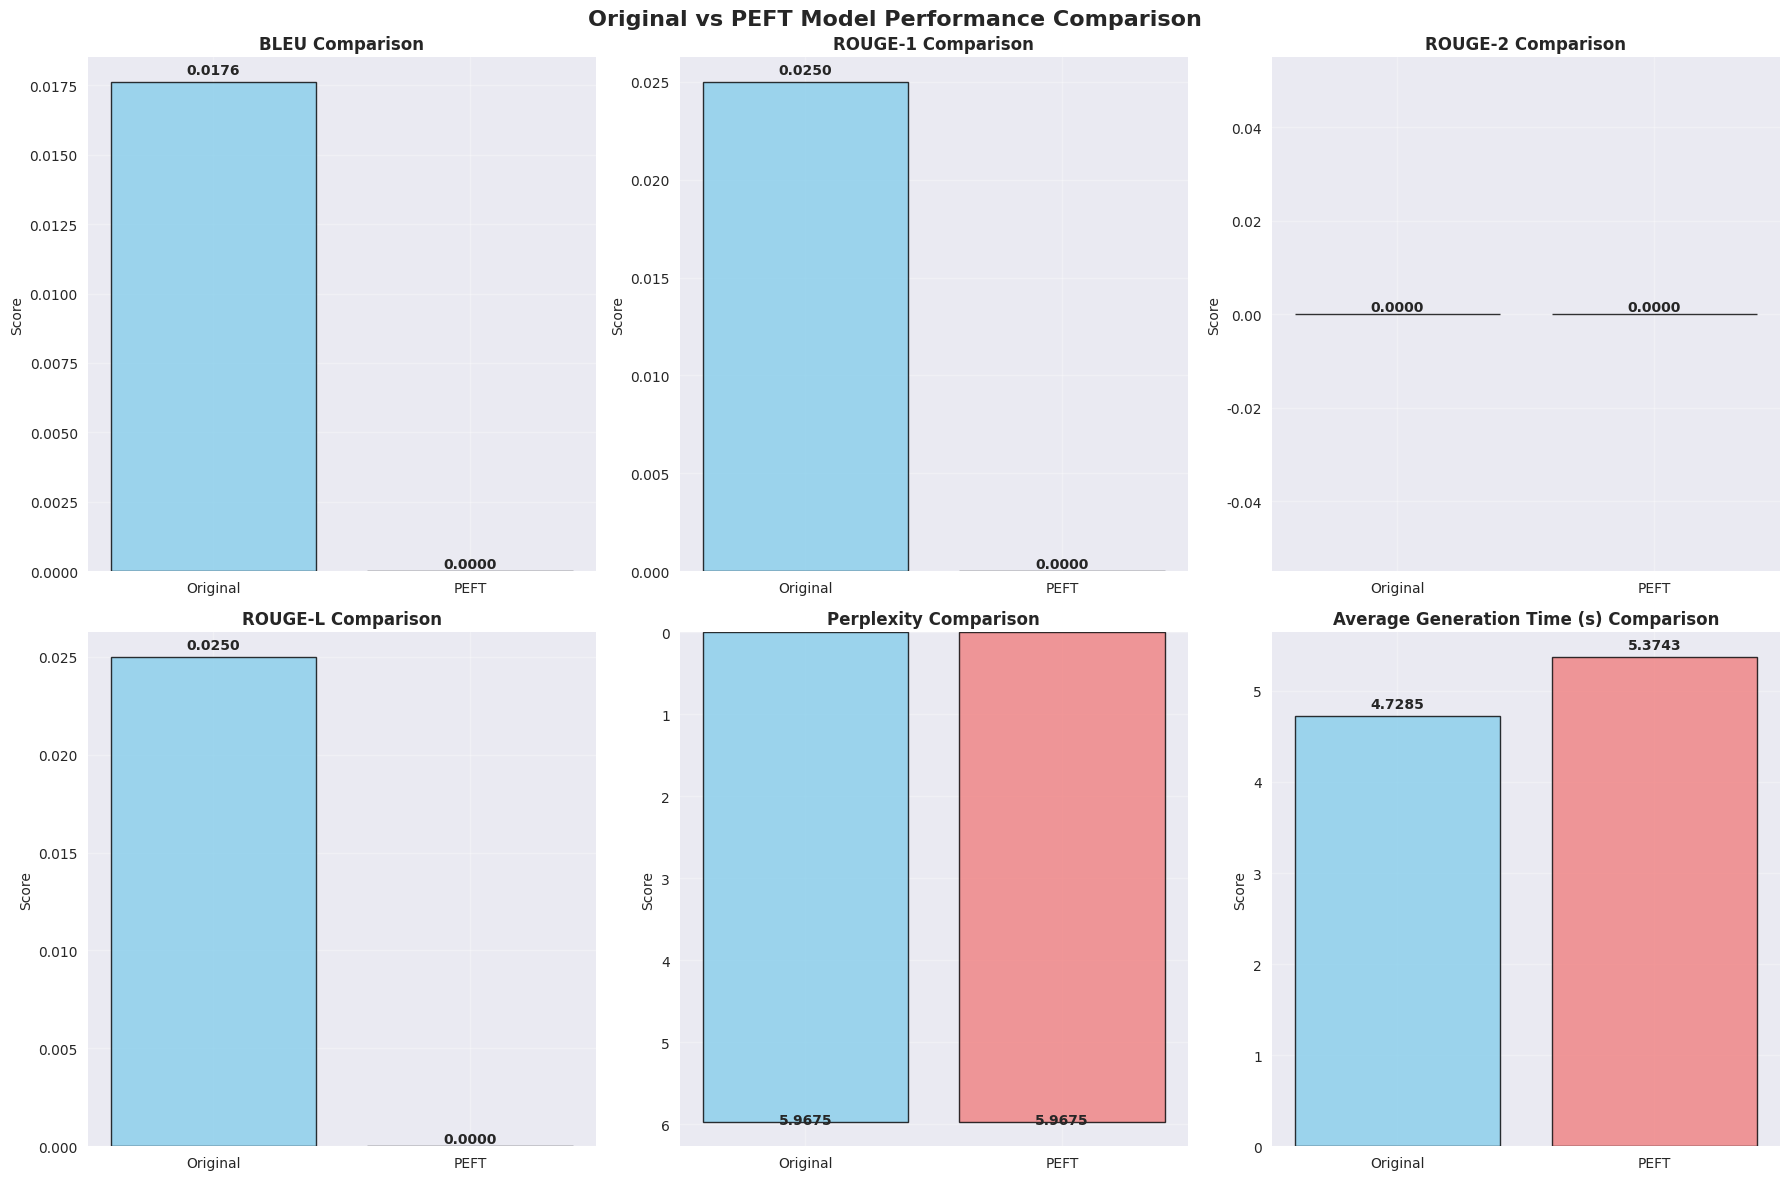


개별 샘플 비교 (첫 3개 프롬프트)

샘플 1:
프롬프트: <s>[INST] 인공지능의 미래는 어떻게 될까요? [/INST]
정답: 인공지능의 미래는 매우 밝습니다. AI 기술이 계속 발전하면서 의료, 교육, 교통 등 다양한 분야에서 혁신을 가져올 것입니다. 하지만 윤리적 고려사항과 일자리 변화에 대한 대비도 필요합니다.

원본 모델 답변:
  인공지능의 미래는 매우 밝습니다. 인공지능의 미래는 우리 삶의 방식을 바꿀 잠재력을 가지고 있습니다. [/INST] 인공지능은 이미 우리의 삶에 큰 영향을 미치고 있으며 앞으로도 그 영향력은 더욱 커질 것입니다. [/INST] 인공지능은 의료, 교육, 엔터테인먼트, 제조 등 다양한 산업에 적용되고 있으며 앞으로도 그 적용 범위가 더욱 확대될 것으로 예상됩니다. [/INST] 인공지능은 의료, 교육, 엔터테인먼트, 제조 등 다양한 산업에 적용되고 있으며 앞으로도 그 적용 범위가 더욱 확대될 것으로 예상됩니다. [/ANS] 인공지능의 미래는 매우 밝습니다. 인공지능은 의료, 교육, 엔터테인먼트, 제조 등 다양한 산업에 적용되고 있으며 앞으로도 그 적용 범위가 더욱 확대될 것으로 예상�

PEFT 모델 답변:
  인공지능의 미래는 인간의 삶을 크게 변화시킬 것입니다.

2021년 기준으로 전 세계적으로 2021년에는 1990년대부터 2020년까지 3000만 명 이상의 사람들이 인공지능으로 인해 사망했습니다. 2030년에는 1000만 명이 넘는 사람들이 사망할 것으로 예상되며, 2050년에는 3억 명이 넘는 사람들이 사망할 것으로 예상됩니다. 2021년부터 2050년까지 20년 동안 3000만 명 이상의 사람들이 사망할 것으로 예상됩니다.

2021년 기준으로 전 세계적으로 1990년대부터 2020년
--------------------------------------------------------------------------------

샘플 2:
프롬프트: <s>[INST] 기후변화에 대응하는 방법을 알려주세요. 

In [44]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Original vs PEFT Model Performance Comparison', fontsize=16, fontweight='bold')

# Metric names and values
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Perplexity', 'Average Generation Time (s)']
original_values = [
    original_results['bleu'],
    original_results['rouge1'],
    original_results['rouge2'],
    original_results['rougeL'],
    original_results['perplexity'],
    original_results['avg_generation_time']
]
peft_values = [
    peft_results['bleu'],
    peft_results['rouge1'],
    peft_results['rouge2'],
    peft_results['rougeL'],
    peft_results['perplexity'],
    peft_results['avg_generation_time']
]

# Draw bar plots for each metric
for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    
    # Data
    x = ['Original', 'PEFT']
    y = [original_values[i], peft_values[i]]
    colors = ['skyblue', 'lightcoral']
    
    # Bar plot
    bars = ax.bar(x, y, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Display values
    for bar, value in zip(bars, y):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Graph settings
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Invert y-axis for Perplexity (lower is better)
    if metric == 'Perplexity':
        ax.invert_yaxis()

plt.tight_layout()
plt.show()


# 개별 샘플 비교
print("\n" + "="*80)
print("개별 샘플 비교 (첫 3개 프롬프트)")
print("="*80)

for i in range(min(3, len(test_prompts))):
    print(f"\n샘플 {i+1}:")
    print(f"프롬프트: {test_prompts[i]}")
    print(f"정답: {test_answers[i]}")
    print(f"\n원본 모델 답변:")
    print(f"  {original_results['predictions'][i]}")
    print(f"\nPEFT 모델 답변:")
    print(f"  {peft_results['predictions'][i]}")
    print("-" * 80)


## 종합 분석 및 결론

In [ ]:
print("\n" + "="*80)
print("종합 분석 및 결론")
print("="*80)

# 전체적인 성능 개선 여부 판단
improvement_count = 0
total_metrics = 0

for idx, row in df_comparison.iterrows():
    metric = row['지표']
    improvement = row['개선율(%)']
    
    if metric == 'Perplexity':  # Perplexity는 낮을수록 좋음
        if improvement < 0:
            improvement_count += 1
    else:  # 나머지 지표는 높을수록 좋음
        if improvement > 0:
            improvement_count += 1
    
    total_metrics += 1

improvement_ratio = (improvement_count / total_metrics) * 100

print(f"\n전체 성능 개선률: {improvement_ratio:.1f}% ({improvement_count}/{total_metrics} 지표에서 개선)")

if improvement_ratio >= 70:
    print("PEFT 모델이 원본 모델 대비 전반적으로 우수한 성능을 보입니다!")
elif improvement_ratio >= 50:
    print("PEFT 모델이 원본 모델 대비 대부분의 지표에서 개선되었습니다.")
elif improvement_ratio >= 30:
    print("PEFT 모델이 일부 지표에서만 개선되었습니다. 추가 튜닝이 필요할 수 있습니다.")
else:
    print("PEFT 모델의 성능 개선이 제한적입니다. 하이퍼파라미터 조정을 고려해보세요.")

# 파라미터 효율성 분석
original_params = sum(p.numel() for p in original_model.parameters())
peft_params = sum(p.numel() for p in peft_model.parameters())
efficiency_ratio = (peft_params / original_params) * 100

print(f"\n파라미터 효율성:")
print(f"  - 원본 모델 파라미터: {original_params:,}")
print(f"  - PEFT 모델 파라미터: {peft_params:,}")
print(f"  - 파라미터 사용률: {efficiency_ratio:.2f}%")

if efficiency_ratio < 10:
    print("매우 효율적인 파라미터 사용 (10% 미만)")
elif efficiency_ratio < 20:
    print("효율적인 파라미터 사용 (20% 미만)")
else:
    print("파라미터 사용량이 높습니다. LoRA 설정을 조정해보세요.")

# 추천사항
print(f"\n추천사항:")
if improvement_ratio < 50:
    print("  - LoRA rank(r) 값을 증가시켜 보세요 (현재: {})".format(lora_r))
    print("  - LoRA alpha 값을 조정해보세요 (현재: {})".format(lora_alpha))
    print("  - 더 많은 훈련 데이터를 사용해보세요")
    print("  - 훈련 에포크 수를 증가시켜보세요")

if efficiency_ratio > 20:
    print("  - LoRA rank(r) 값을 감소시켜 파라미터 효율성을 높여보세요")
    print("  - target_modules를 줄여보세요")

print("  - 다양한 temperature와 top_p 값으로 생성 품질을 테스트해보세요")
print("  - 더 큰 테스트 데이터셋으로 성능을 재평가해보세요")

print("\n" + "="*80)
print("모델 성능 비교 완료!")
print("="*80)



종합 분석 및 결론

전체 성능 개선률: 16.7% (1/6 지표에서 개선)
PEFT 모델의 성능 개선이 제한적입니다. 하이퍼파라미터 조정을 고려해보세요.

파라미터 효율성:
  - 원본 모델 파라미터: 2,416,386,560
  - PEFT 모델 파라미터: 2,416,386,560
  - 파라미터 사용률: 100.00%
파라미터 사용량이 높습니다. LoRA 설정을 조정해보세요.

추천사항:
  - LoRA rank(r) 값을 증가시켜 보세요 (현재: 32)
  - LoRA alpha 값을 조정해보세요 (현재: 16)
  - 더 많은 훈련 데이터를 사용해보세요
  - 훈련 에포크 수를 증가시켜보세요
  - LoRA rank(r) 값을 감소시켜 파라미터 효율성을 높여보세요
  - target_modules를 줄여보세요
  - 다양한 temperature와 top_p 값으로 생성 품질을 테스트해보세요
  - 더 큰 테스트 데이터셋으로 성능을 재평가해보세요

모델 성능 비교 완료!
